In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression,Ridge

from scipy.stats.stats import pearsonr

from model_functions import *

pd.set_option('display.max_columns', 500)

### 1. Подготовка

#### Данные

In [2]:
data_month=pd.read_excel('data_case.xlsx',sheet_name='month')
data_quarter=pd.read_excel('data_case.xlsx',sheet_name='quarter')
descriptions=pd.read_excel('data_case.xlsx',sheet_name='description')

#### Генерим признаки

In [5]:
# Для помесячных данных
# Темпы роста/прироста
data_growth=gen_growth(data_month,data_month.drop(['period','target'],axis=1).columns)
# Лаги
data_lag_1_all=gen_lag(data_month,data_month.drop(['period','target'],axis=1).columns,1)
data_lag_1_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,1)
data_lag_2_all=gen_lag(data_month,data_month.drop(['period','target'],axis=1).columns,2)
data_lag_2_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,2)
data_lag_3_all=gen_lag(data_month,data_month.drop(['period','target'],axis=1).columns,3)
data_lag_3_growth=gen_lag(data_growth,data_growth.drop(['period'],axis=1).columns,3)
# Объединяем
features=data_growth.merge(data_lag_1_all,on='period'). \
                          merge(data_lag_1_growth,on='period'). \
                          merge(data_lag_2_all,on='period'). \
                          merge(data_lag_2_growth,on='period'). \
                          merge(data_lag_3_all,on='period'). \
                          merge(data_lag_3_growth,on='period') 
# Удаляем пропуски
# data_model=data_model.dropna()
print(f'Число наблюдений: {len(features)}')
print(f'Начальный период: {features["period"].min()}')
print(f'Конечный период: {features["period"].max()}'
     )

Число наблюдений: 162
Начальный период: 2009-08-01 00:00:00
Конечный период: 2023-01-01 00:00:00


#### Генерим варианты таргета

In [10]:
# Вариант 1. Исходный таргет
data_model_target=features.merge(data_month[['period','target']],on='period')
# Вариант 2. Темпы прироста
target_growth=gen_growth(data_month,['target'])
data_model_delta=features.merge(target_growth[['period','delta_rate_target']],on='period')
data_model_delta.rename({'delta_rate_target': 'target'},inplace=True,axis=1)
# Вариант 3. Первые разности темпов прироста
diff_delta=pd.DataFrame({'period':data_month.period[2:], 
                          'target':target_growth['delta_rate_target'][1:].values-target_growth['delta_rate_target'][:-1].values })
data_model_diff_delta=features.merge(diff_delta[['period','target']],on='period')

### 2. Корреляции

#### Убираем Nan и inf

In [14]:
# Обрабатываем пропуски
data_model_target=data_model_target.fillna(data_model_target.median())
data_model_delta=data_model_delta.fillna(data_model_delta.median())
data_model_diff_delta=data_model_diff_delta.fillna(data_model_diff_delta.median())
# Обрабатываем inf
data_model_target.replace([np.inf, -np.inf], 0, inplace=True)
data_model_delta.replace([np.inf, -np.inf], 0, inplace=True)
data_model_diff_delta.replace([np.inf, -np.inf], 0, inplace=True)

#### Смотрим корреляции

In [73]:
# Прогоняем по двухлеткам
for year in range(2010,2022):
    print(f'Период: {year}-{year+1}')
    ## Данные для анализа
    data_year=data_model_delta[(data_model_delta.period<f'{year}-01-01')|(data_model_delta.period>=f'{year+1}-12-31')]
    ## Датафрейм для заполнения
    corr_data=pd.DataFrame(columns=['feature','correlation'])
    ## Считаем корреляции с таргетом для каждого признака
    for c in data_year.drop(['period','target'],axis=1).columns:
        corr_data.loc[len(corr_data.index)]=[c,pearsonr(data_year[c],data_year['target'])[0]]
    ## Сортируем по убыванию
    corr_data=corr_data.sort_values(by='correlation',ascending=False)
    ## Выводим топ-10
    display(corr_data.head(10))

Период: 2010-2011


,feature,correlation
323,l3_rtsi_last,0.572797
321,l3_rtsi_max,0.569325
322,l3_rtsi_min,0.568117
205,l2_rtsi_max,0.528605
206,l2_rtsi_min,0.526838
207,l2_rtsi_last,0.512753
338,l3_ofz_diff_30_1,0.504896
222,l2_ofz_diff_30_1,0.484320
343,l3_brent_price,0.479176
227,l2_brent_price,0.476821


Период: 2011-2012


,feature,correlation
322,l3_rtsi_min,0.519490
323,l3_rtsi_last,0.509699
321,l3_rtsi_max,0.499085
205,l2_rtsi_max,0.453552
206,l2_rtsi_min,0.451539
207,l2_rtsi_last,0.435936
338,l3_ofz_diff_30_1,0.417246
222,l2_ofz_diff_30_1,0.401078
89,l1_rtsi_max,0.392222
343,l3_brent_price,0.385729


Период: 2012-2013


,feature,correlation
322,l3_rtsi_min,0.619130
321,l3_rtsi_max,0.618193
323,l3_rtsi_last,0.617076
205,l2_rtsi_max,0.580098
207,l2_rtsi_last,0.552884
206,l2_rtsi_min,0.540000
89,l1_rtsi_max,0.515667
338,l3_ofz_diff_30_1,0.509915
343,l3_brent_price,0.491322
336,l3_ofz_diff_10_1,0.487903


Период: 2013-2014


,feature,correlation
323,l3_rtsi_last,0.651876
321,l3_rtsi_max,0.648974
322,l3_rtsi_min,0.646827
205,l2_rtsi_max,0.612827
343,l3_brent_price,0.602523
227,l2_brent_price,0.590164
207,l2_rtsi_last,0.583551
206,l2_rtsi_min,0.578557
111,l1_brent_price,0.557942
89,l1_rtsi_max,0.545785


Период: 2014-2015


,feature,correlation
321,l3_rtsi_max,0.598121
322,l3_rtsi_min,0.589532
323,l3_rtsi_last,0.589002
343,l3_brent_price,0.582163
227,l2_brent_price,0.565345
205,l2_rtsi_max,0.545168
111,l1_brent_price,0.532105
207,l2_rtsi_last,0.503973
206,l2_rtsi_min,0.497308
89,l1_rtsi_max,0.467462


Период: 2015-2016


,feature,correlation
321,l3_rtsi_max,0.499474
322,l3_rtsi_min,0.484669
323,l3_rtsi_last,0.484191
343,l3_brent_price,0.448247
205,l2_rtsi_max,0.436292
227,l2_brent_price,0.432867
111,l1_brent_price,0.396676
207,l2_rtsi_last,0.393060
206,l2_rtsi_min,0.380061
160,l1_delta_rate_ofz_1,0.364800


Период: 2016-2017


,feature,correlation
321,l3_rtsi_max,0.556785
323,l3_rtsi_last,0.552279
322,l3_rtsi_min,0.550450
205,l2_rtsi_max,0.508193
207,l2_rtsi_last,0.478084
206,l2_rtsi_min,0.471821
343,l3_brent_price,0.455427
338,l3_ofz_diff_30_1,0.448918
227,l2_brent_price,0.448313
89,l1_rtsi_max,0.430853


Период: 2017-2018


,feature,correlation
321,l3_rtsi_max,0.622520
323,l3_rtsi_last,0.614603
322,l3_rtsi_min,0.612438
205,l2_rtsi_max,0.580922
207,l2_rtsi_last,0.549114
206,l2_rtsi_min,0.540345
343,l3_brent_price,0.520542
89,l1_rtsi_max,0.516799
227,l2_brent_price,0.516529
338,l3_ofz_diff_30_1,0.513230


Период: 2018-2019


,feature,correlation
321,l3_rtsi_max,0.633228
322,l3_rtsi_min,0.624233
323,l3_rtsi_last,0.623801
205,l2_rtsi_max,0.591584
207,l2_rtsi_last,0.559158
206,l2_rtsi_min,0.550580
343,l3_brent_price,0.538044
227,l2_brent_price,0.531539
338,l3_ofz_diff_30_1,0.530063
89,l1_rtsi_max,0.529912


Период: 2019-2020


,feature,correlation
321,l3_rtsi_max,0.639398
323,l3_rtsi_last,0.628230
322,l3_rtsi_min,0.621818
205,l2_rtsi_max,0.596235
227,l2_brent_price,0.577202
343,l3_brent_price,0.577173
207,l2_rtsi_last,0.576834
111,l1_brent_price,0.571040
206,l2_rtsi_min,0.564933
89,l1_rtsi_max,0.548409


Период: 2020-2021


,feature,correlation
321,l3_rtsi_max,0.633505
323,l3_rtsi_last,0.622770
322,l3_rtsi_min,0.612857
343,l3_brent_price,0.611539
227,l2_brent_price,0.607171
205,l2_rtsi_max,0.594304
111,l1_brent_price,0.593459
207,l2_rtsi_last,0.572733
338,l3_ofz_diff_30_1,0.557560
206,l2_rtsi_min,0.555319


Период: 2021-2022


,feature,correlation
321,l3_rtsi_max,0.656002
322,l3_rtsi_min,0.654370
323,l3_rtsi_last,0.648797
205,l2_rtsi_max,0.614396
338,l3_ofz_diff_30_1,0.595641
207,l2_rtsi_last,0.585801
206,l2_rtsi_min,0.581516
222,l2_ofz_diff_30_1,0.572077
343,l3_brent_price,0.570522
227,l2_brent_price,0.567922


In [74]:
corr_data.head(10)['feature'].to_list()

['l3_rtsi_max',
 'l3_rtsi_min',
 'l3_rtsi_last',
 'l2_rtsi_max',
 'l3_ofz_diff_30_1',
 'l2_rtsi_last',
 'l2_rtsi_min',
 'l2_ofz_diff_30_1',
 'l3_brent_price',
 'l2_brent_price']

#### Пробуем

Год: 2010
Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),19.97,-117594.79,5889.57
MAPE (%),33.48,154.35,3.61


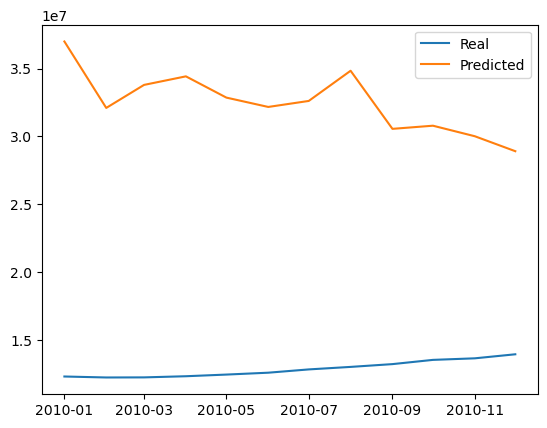

Год: 2011
Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),21.88,-21541.85,985.55
MAPE (%),36.40,124.60,2.42


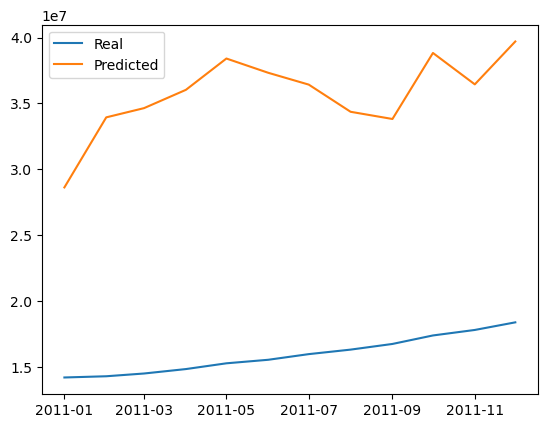

Год: 2012
Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),20.52,-3726.40,182.60
MAPE (%),39.51,43.79,0.11


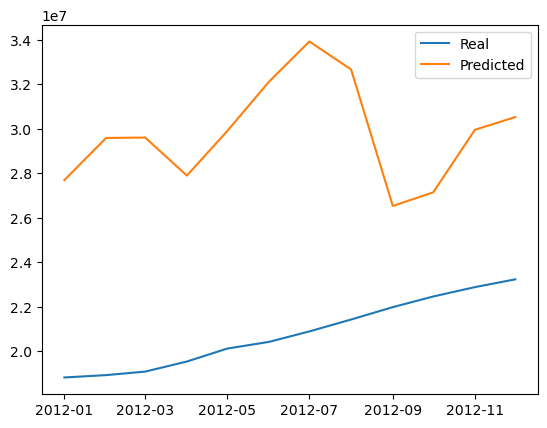

Год: 2013
Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),21.78,-1017.59,47.72
MAPE (%),40.15,15.65,0.61


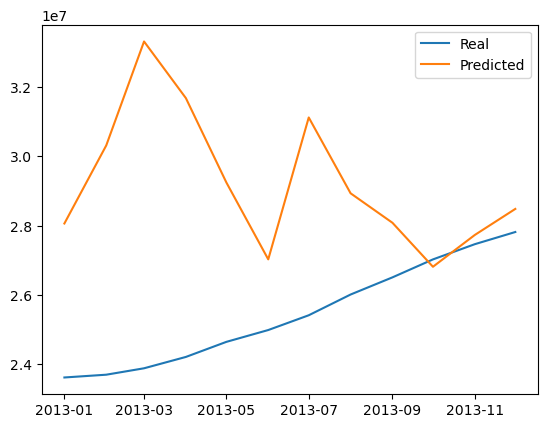

Год: 2014
Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),23.15,-1198.40,52.77
MAPE (%),39.34,12.17,0.69


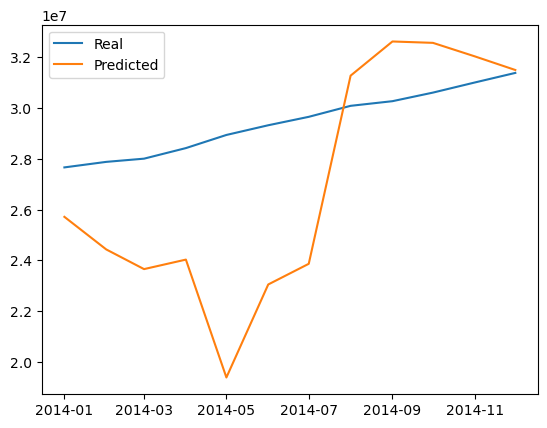

Год: 2015
Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),32.22,-546524.57,16963.28
MAPE (%),35.92,59.37,0.65


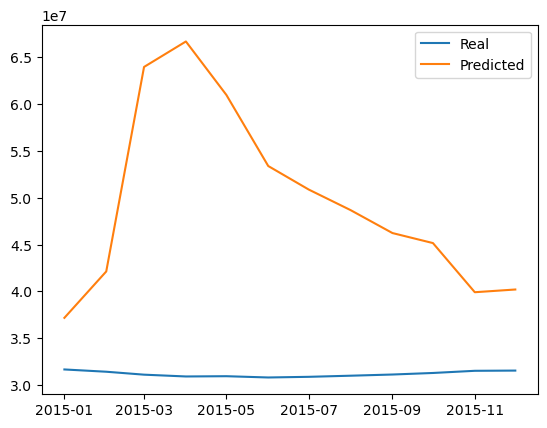

Год: 2016
Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),26.75,-181279.98,6777.82
MAPE (%),37.86,39.18,0.03


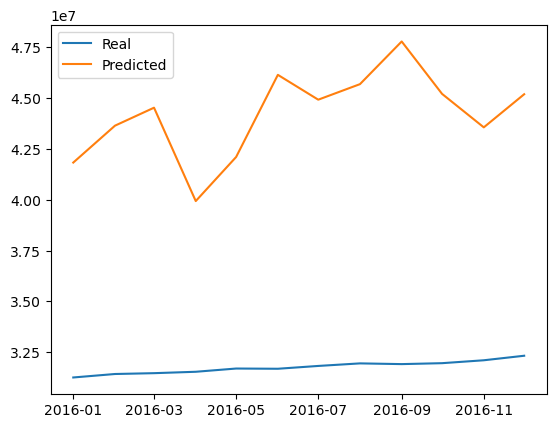

Год: 2017
Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),24.59,-8382.97,341.91
MAPE (%),39.46,18.47,0.53


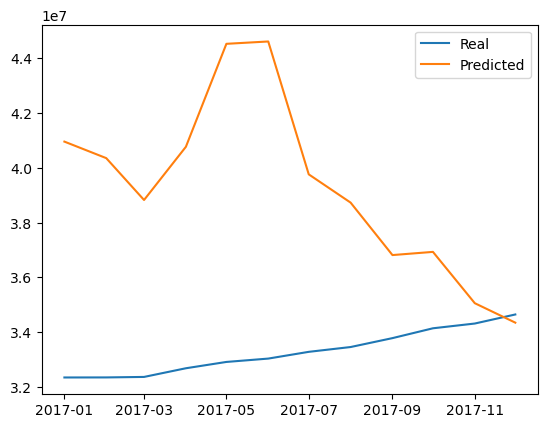

Год: 2018
Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),24.84,-2368.90,96.37
MAPE (%),38.11,21.15,0.45


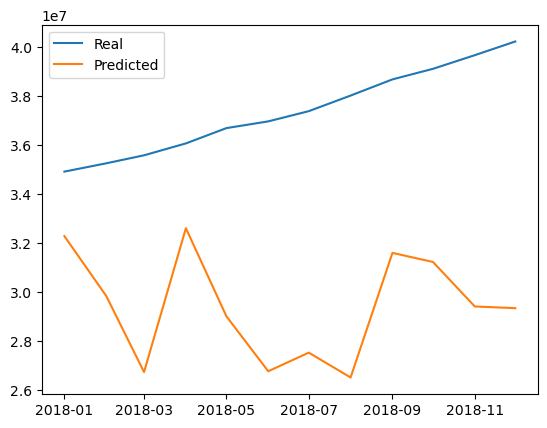

Год: 2019
Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),22.83,-2632.41,116.30
MAPE (%),38.81,17.50,0.55


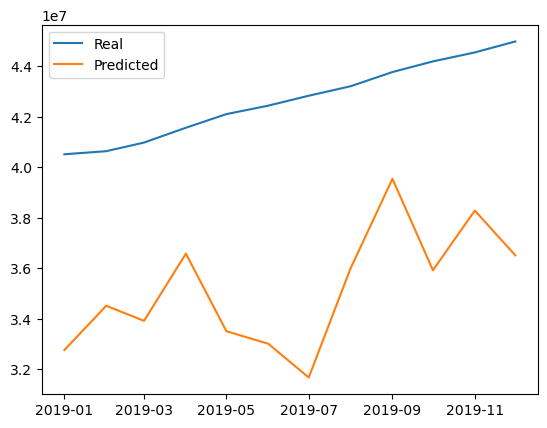

Год: 2020
Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),22.89,-5929.01,260.02
MAPE (%),37.89,25.06,0.34


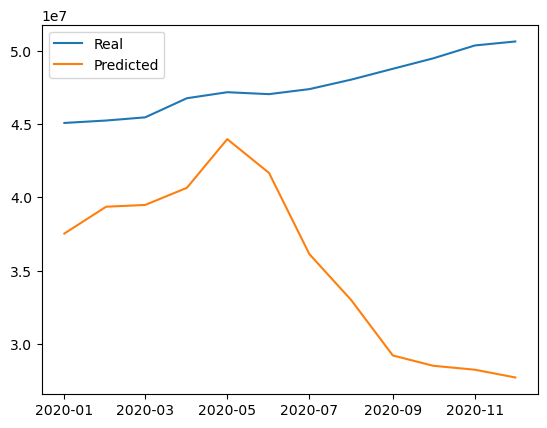

Год: 2021
Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),25.23,-5486.94,218.48
MAPE (%),35.01,44.92,0.28


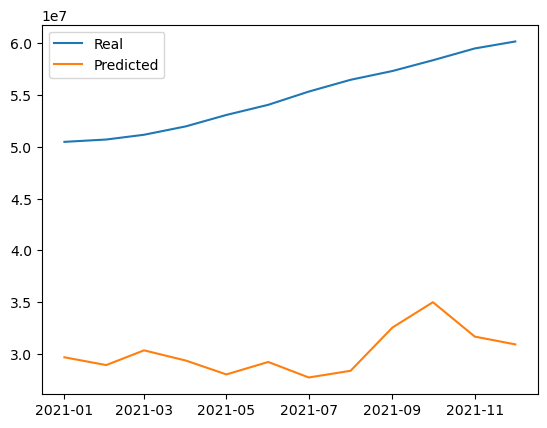

Год: 2022
Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),41.27,-17877.09,434.17
MAPE (%),31.16,65.65,1.11


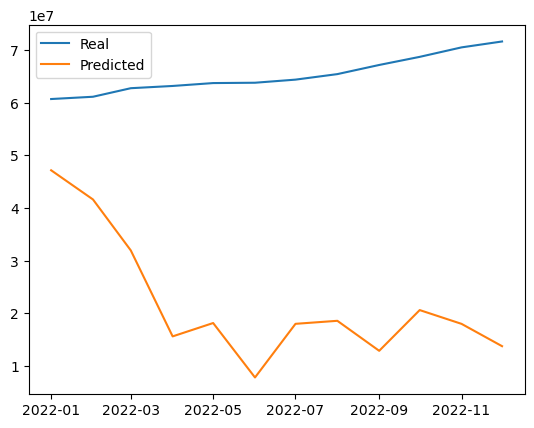

In [75]:
feat_list=['l3_rtsi_max',
 'l3_rtsi_min',
 'l3_rtsi_last',
 'l2_rtsi_max',
 'l3_ofz_diff_30_1',
 'l2_rtsi_last',
 'l2_rtsi_min',
 'l2_ofz_diff_30_1',
 'l3_brent_price',
 'l2_brent_price']

for year in range(2010,2023):
    print(f'Год: {year}')
    ## Берём данные для модели
    data_model=data_model_target[['period','target']+feat_list]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<f'{year}-01-01')|(data_model.period>=f'{year}-12-31')]
    data_test=data_model[(data_model.period>=f'{year}-01-01')&(data_model.period<f'{year}-12-31')]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=Ridge().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,y_test, label='Real')
    plt.plot(data_test.period,y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

### 3. Отбор признаков с наименьшими колебаниями коэффициентов

#### Оцениваем регрессии

In [64]:
# Датафрейм для заполнения
coef_data=pd.DataFrame()
coef_data['feature']=data_model_diff_delta.drop(['period','target'],axis=1).columns
# Прогоняем по двухлеткам
for year in range(2010,2022):
    # print(f'Период: {year}-{year+1}')
    ## Данные для анализа
    data_year=data_model_diff_delta[(data_model_diff_delta.period<f'{year}-01-01')|(data_model_diff_delta.period>=f'{year+1}-12-31')]
    ## Выделяем X и y
    X,y=data_year.drop(['period','target'],axis=1),data_year['target']
    ## Строим линейные регрессии
    model=Ridge().fit(X,y)
    ## Добавляем коэффициенты
    coef_data[f'{year}_{year+1}']=model.coef_

#### Считаем коэффициенты вариации

In [65]:
coef_data['variation']=abs(np.std(coef_data[coef_data.columns[1:]],axis=1)/np.mean(coef_data[coef_data.columns[1:]],axis=1))

In [69]:
coef_data.sort_values(by='variation')

,feature,2010_2011,2011_2012,2012_2013,2013_2014,2014_2015,2015_2016,2016_2017,2017_2018,2018_2019,2019_2020,2020_2021,2021_2022,variation
432,l3_abs_growth_credit_volume,-5.022472e-09,-1.252553e-08,-1.201390e-08,-1.653521e-08,-1.641202e-08,-1.634124e-08,-1.859475e-08,-1.680810e-08,-1.386414e-08,-1.984353e-08,-1.492415e-08,-1.996601e-08,0.258146
137,l1_abs_growth_sber_orders,3.934743e-06,2.790015e-06,1.966644e-06,2.925631e-06,3.150198e-06,3.442357e-06,2.201657e-06,3.974142e-06,2.447884e-06,1.887227e-06,4.262566e-06,2.509989e-06,0.261005
316,l2_abs_growth_credit_volume,-8.114676e-09,-9.897172e-09,-1.260355e-08,-1.281299e-08,-1.233719e-08,-1.773088e-08,-1.304264e-08,-1.818663e-08,-2.004155e-08,-2.126361e-08,-1.591973e-08,-1.208417e-08,0.269662
375,l3_abs_growth_dji_close,1.446924e-04,2.547680e-04,2.623175e-04,2.124871e-04,1.677314e-04,2.239912e-04,2.805896e-04,2.513283e-04,2.000122e-04,2.349136e-04,6.365042e-05,2.427229e-04,0.275782
422,l3_delta_rate_brent_price,1.953035e-06,2.773036e-06,3.583390e-06,3.453791e-06,2.267232e-06,1.616088e-06,4.538508e-06,4.247705e-06,2.323231e-06,3.587381e-06,1.920744e-06,2.916566e-06,0.311201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,l1_index_ixic_volume,2.914032e-08,2.320300e-09,-1.869064e-08,6.400204e-09,-7.885382e-09,-2.246066e-09,3.786180e-09,-7.297006e-09,-2.354938e-08,-1.427938e-08,1.521509e-08,1.240297e-08,37.147268
157,l1_delta_rate_ixic_volume,2.914032e-06,2.320300e-07,-1.869064e-06,6.400204e-07,-7.885382e-07,-2.246066e-07,3.786180e-07,-7.297006e-07,-2.354938e-06,-1.427938e-06,1.521509e-06,1.240297e-06,37.147268
259,l2_abs_growth_dji_close,5.089826e-05,-1.077778e-05,1.655400e-05,1.980668e-05,3.356515e-05,1.981727e-05,2.651193e-05,-1.229743e-05,4.249846e-05,-5.318800e-05,-1.086180e-04,-2.985599e-05,103.461012
324,l3_sber_last,2.061861e-06,6.120182e-07,-1.602073e-06,4.346215e-07,-1.706588e-06,-2.030427e-06,2.112171e-06,4.069769e-06,8.570550e-07,-2.779324e-06,-2.746440e-06,7.954976e-07,319.916402


In [70]:
top_feats=coef_data.sort_values(by='variation').head(20)['feature'].tolist()

#### Прогоняем

Год: 2010
Год для тестирования: 2010


,Train,Test,Relative Difference
R2 (%),33.94,-36511261.75,1075760.04
MAPE (%),132.61,91615.89,689.87


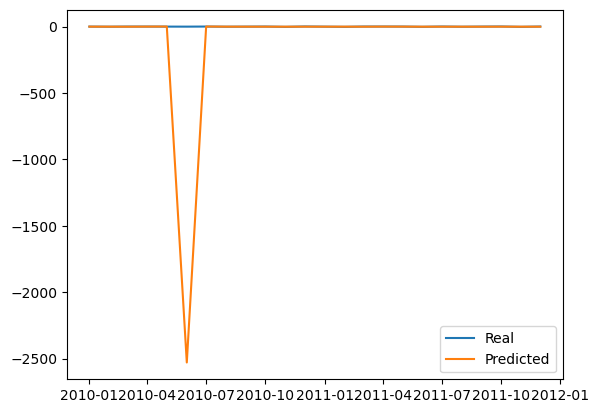

Год: 2011
Год для тестирования: 2011


,Train,Test,Relative Difference
R2 (%),34.09,15.92,0.53
MAPE (%),117.24,119.37,0.02


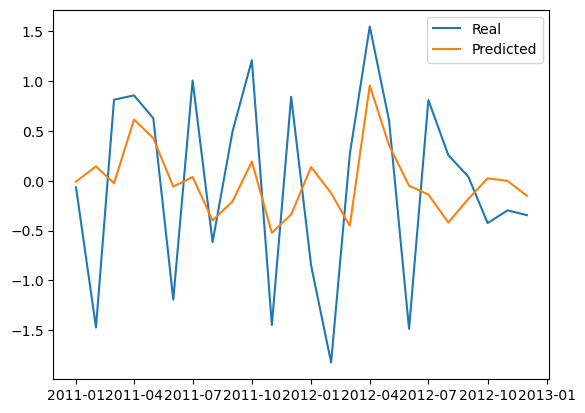

Год: 2012
Год для тестирования: 2012


,Train,Test,Relative Difference
R2 (%),32.96,8.05,0.76
MAPE (%),116.07,141.05,0.22


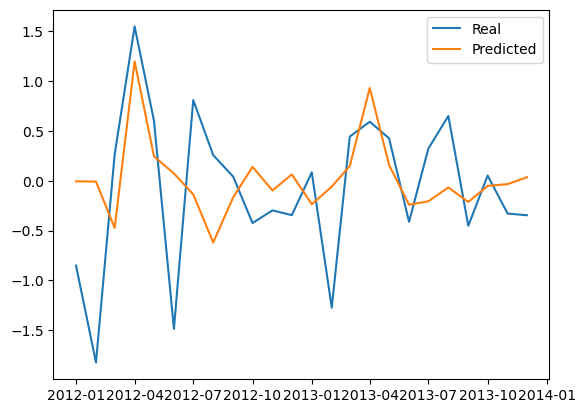

Год: 2013
Год для тестирования: 2013


,Train,Test,Relative Difference
R2 (%),33.09,17.15,0.48
MAPE (%),122.66,102.26,0.17


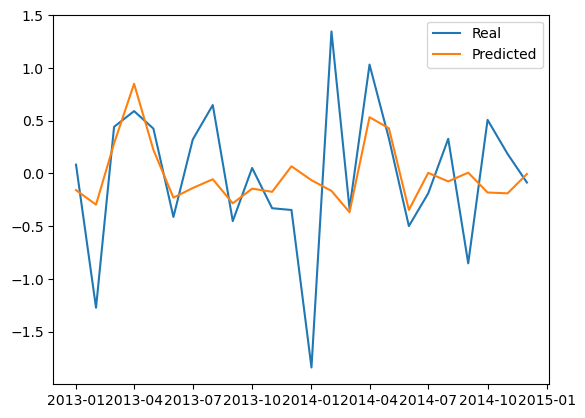

Год: 2014
Год для тестирования: 2014


,Train,Test,Relative Difference
R2 (%),34.08,9.21,0.73
MAPE (%),115.31,133.98,0.16


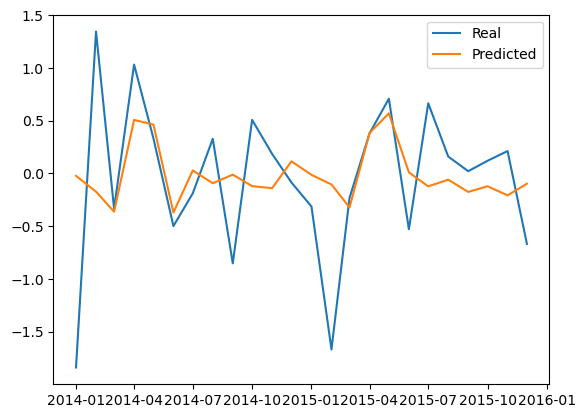

Год: 2015
Год для тестирования: 2015


,Train,Test,Relative Difference
R2 (%),34.29,0.85,0.98
MAPE (%),114.60,156.30,0.36


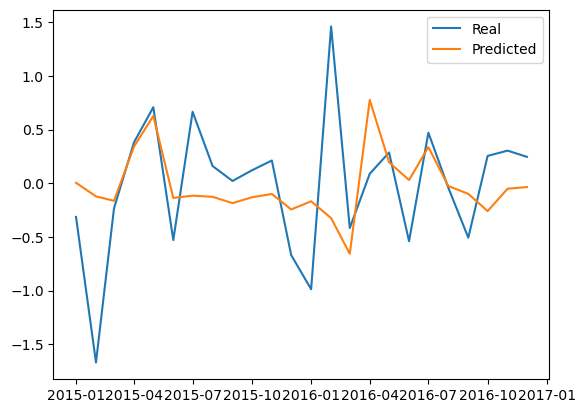

Год: 2016
Год для тестирования: 2016


,Train,Test,Relative Difference
R2 (%),33.94,-8.78,1.26
MAPE (%),125.28,126.99,0.01


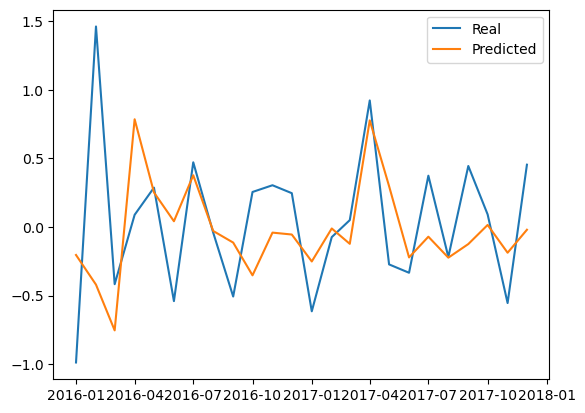

Год: 2017
Год для тестирования: 2017


,Train,Test,Relative Difference
R2 (%),31.57,20.63,0.35
MAPE (%),115.56,176.64,0.53


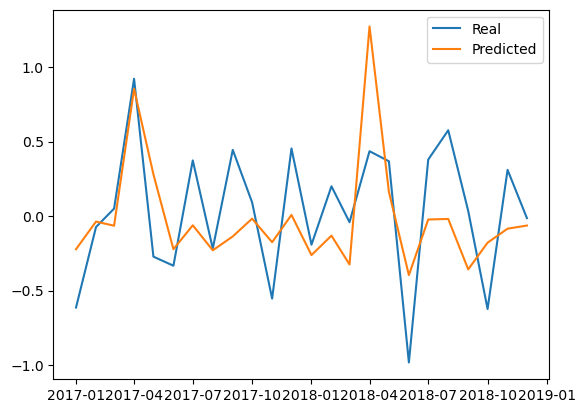

Год: 2018
Год для тестирования: 2018


,Train,Test,Relative Difference
R2 (%),31.59,21.34,0.32
MAPE (%),114.49,171.28,0.50


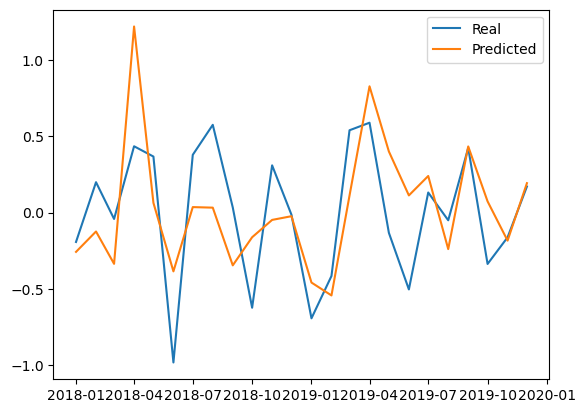

Год: 2019
Год для тестирования: 2019


,Train,Test,Relative Difference
R2 (%),29.34,25.25,0.14
MAPE (%),111.26,109.48,0.02


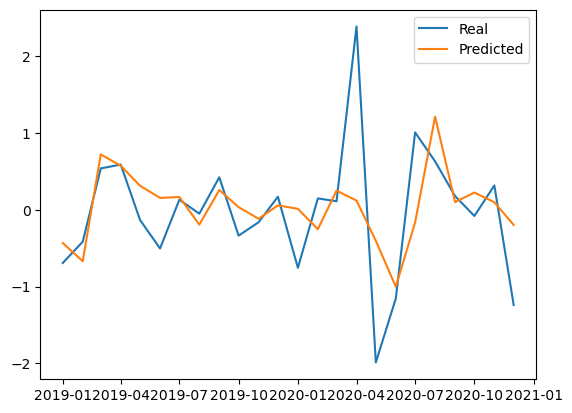

Год: 2020
Год для тестирования: 2020


,Train,Test,Relative Difference
R2 (%),29.98,22.74,0.24
MAPE (%),111.19,101.24,0.09


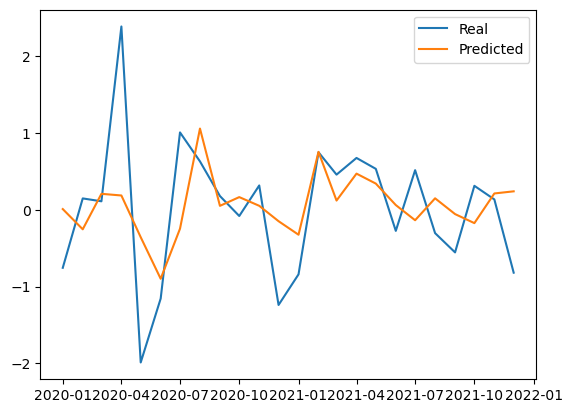

Год: 2021
Год для тестирования: 2021


,Train,Test,Relative Difference
R2 (%),30.04,20.05,0.33
MAPE (%),127.45,138.68,0.09


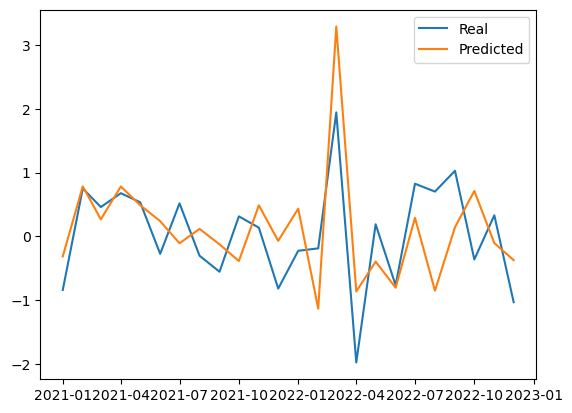

Год: 2022
Год для тестирования: 2022


,Train,Test,Relative Difference
R2 (%),30.53,11.61,0.62
MAPE (%),125.89,175.91,0.40


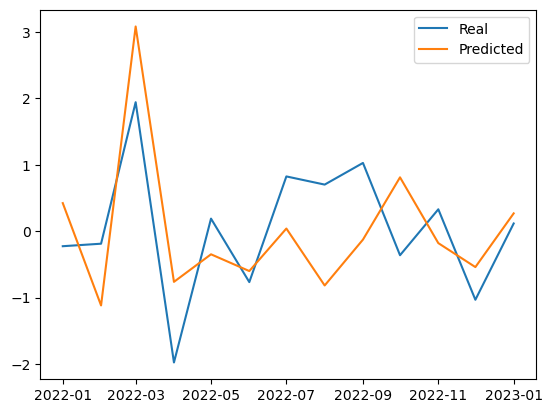

In [72]:
for year in range(2010,2023):
    print(f'Год: {year}')
    ## Берём данные для модели
    data_model=data_model_diff_delta[['period','target']+top_feats]
    ## Выделяем train/test
    data_train=data_model[(data_model.period<f'{year}-01-01')|(data_model.period>=f'{year+1}-12-31')]
    data_test=data_model[(data_model.period>=f'{year}-01-01')&(data_model.period<f'{year+1}-12-31')]
    print(f'Год для тестирования: {year}')
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=Ridge().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,y_test, label='Real')
    plt.plot(data_test.period,y_test_pred, label='Predicted')
    plt.legend()
    plt.show()

### 4. Объединяем подходы